# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 2:  $k$-NN and Linear Regression 

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

# <div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore $k$-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York City at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

## <div class="exercise"> <b> Question 1  [13 pts]</b> </div>

**1.1 [2 pts]**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2 [3 pts]**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.

**1.3 [4 pts]**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4 [4 pts]**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.


### Answers

**1.1 [2 pts]. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.**

In [5]:
# read the file
data = pd.read_csv("./data/nyc_taxi.csv")

In [6]:
# split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)


In [10]:
# take a quick look at the data
print(len(train_data))
print(len(test_data))
print(test_data.head())

1000
250
      TimeMin  PickupCount  Day
1052      486           34  Mon
916       420           13  Sat
284      1138           75  Sat
176       645           22  Thu
219      1140           62  Fri


**1.2 [3 pts]. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.**

In [14]:
# exploratory analysis
print("The highest number of minutes in the data is:", max(data['TimeMin']), ". A day can have", 60*24, "minutes")

the highest number of minutes in the data is: 1438 . A day can have 1440 minutes


In [16]:
# look at some basic statistics 
data.describe()

,TimeMin,PickupCount
count,1250.00000,1250.000000
mean,702.46800,33.230400
std,405.49001,19.136391
min,4.00000,1.000000
25%,361.50000,17.000000
50%,688.50000,33.000000
75%,1046.75000,46.000000
max,1438.00000,116.000000


In [27]:
# list any rows with nulls
data[data.isnull().any(axis=1)]

,TimeMin,PickupCount,Day


**Comment:** everything looks pretty clean and normal. We're not observing any strange values, and there are no nulls. We do expect there will be skewness in the data (there should be more rides at night).

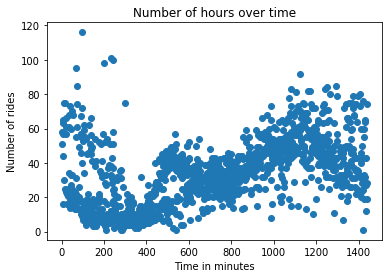

In [21]:
# scatterplot 
plt.scatter(data['TimeMin'],data['PickupCount'])
plt.title("Number of hours over time")
plt.xlabel("Time in minutes")
plt.ylabel("Number of rides")

plt.show()

**Comment:** the relationship seems to be curvilinear. There seem to be some outliers in the early parts of the night as well. I'm assuming this will be correclated to e.g. the day, with more rides happening over the weekend at night.

**1.3 [4 pts]. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**



Taxi usage seems at low at six a clock in the morning, when the day starts for most people, and most partyers have settled for the night. As the day moves forward, the number of rides goes up. During the early hours in the morning, there seems to some outliers. I'm assuming this will be correclated to e.g. the day of the week, with more night rides happening over the weekend. Overall the relationship seems to be curvilinear

**1.4 [4 pts]. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.**

We hypothesize the "low" is caused by lower morning traffic during the morning peak.
Below plots demonstrate how weekend rides are indeed low during 500-550 minute time window.


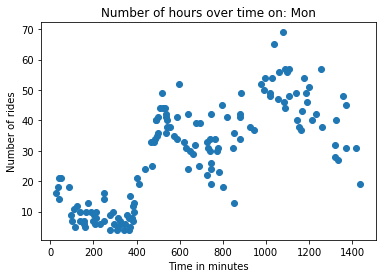

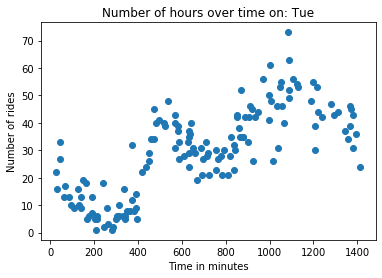

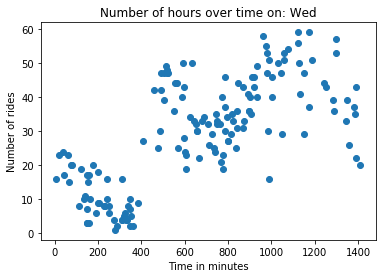

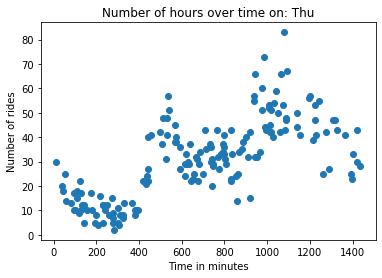

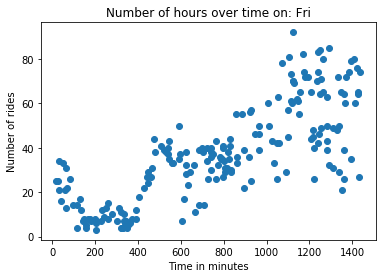

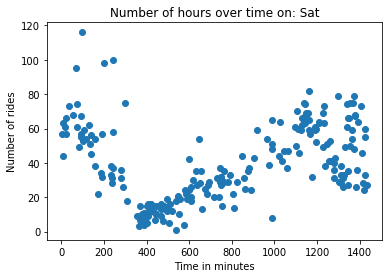

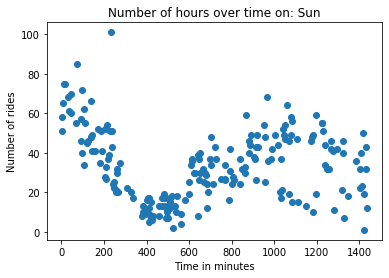

In [51]:
days = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for day in days:
    one_day_data = data[data["Day"] == day]
    plt.scatter(one_day_data['TimeMin'],one_day_data['PickupCount'])
    title = "Number of hours over time on: " + day
    plt.title(title)
    plt.xlabel("Time in minutes")
    plt.ylabel("Number of rides")
    plt.show()


## <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen $k$-Nearest Neighbors ($k$-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run $k$-NN Regression. 


**2.1 [4 pts]**. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2 [6 pts]**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3 [3 pts]**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4 [3 pts]**. Plot, in a single figure, the two 'curves' of $R^2$ values from the models on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5 [9 pts]**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

### Answers

**2.1 [4 pts]. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`).**


In [121]:
# Make our lives easy by storing the different regressors in a dictionary
KNNModels = {}

# Make our lives easier by entering the k values from a list
k_list = [1,10,75,250,500,750,1000]

# shape the data as expected by the algorithm
X_train = train_data['TimeMin']
X_train_np = X_train.to_numpy().reshape(-1,1)

y_train = train_data['PickupCount']
y_train_np = y_train.to_numpy().reshape(-1,1)

X_test = test_data['TimeMin']
X_test_np = X_test.to_numpy().reshape(-1,1)

y_test = test_data['PickupCount']
y_test_np = y_test.to_numpy().reshape(-1,1)

# Do a bunch of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train_np, y_train_np)
    # Store the regressors in a dictionary
    KNNModels[k] = knnreg 

# Print the dictionary to see what we have
KNNModels


{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'),
 75: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                     weights='uniform'),
 250: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform'),
 500: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform'),
 750: KNeighborsRegressor(algorit

In [58]:
np(train_data['TimeMin']

346      749
1027     244
126      745
814     1177
908      833
        ... 
298      520
319      499
587     1292
399      535
141      211
Name: TimeMin, Length: 1000, dtype: int64


**2.2 [5 pts].  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a line plot of predictions for `PickupCount` vs  a dummy `TimeMin` using `np.arange(np.min(train['TimeMin']),np.max(train['TimeMin']),1)`.  Do the same for the test set in separate plots.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set.** 

**Hints**:
1. Each subplot should use different color to distinguish k-NN regression prediction curve from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  

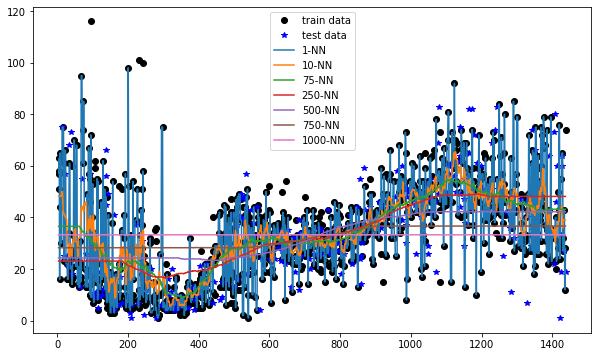

In [122]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

# scatter plots can be created with iether the scatter or plot functions (with an additional argument)
ax.plot(X_train, y_train, 'o', label="train data", c='black')
ax.plot(X_test, y_test, '*', label="test data", c="blue")

dummy_train = np.arange(np.min(X_train),np.max(X_train),1).reshape(-1,1)

# let's unpack the dictionary to its elements (items) which is the k and Regressor
for k, model in knndict.items():
    predictions = model.predict(dummy_train) 
    ax.plot(dummy_train, predictions, label="{}-NN".format(k))

ax.legend();

count: 1 row 0 k 1
count: 2 row 1 k 10
count: 3 row 2 k 75
count: 4 row 3 k 250
count: 5 row 4 k 500
count: 6 row 5 k 750
count: 7 row 6 k 1000


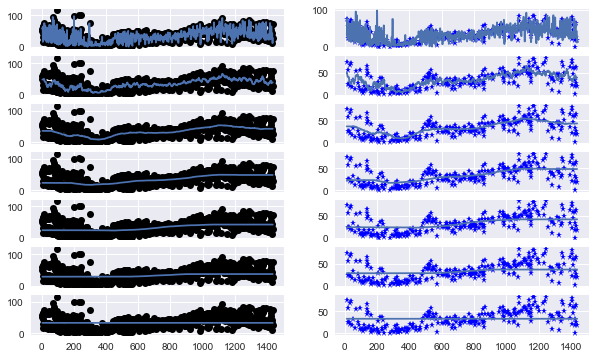

In [126]:
plt.style.use('seaborn')
fig, ax = plt.subplots(7,2, figsize=(10,6))

# scatter plots can be created with iether the scatter or plot functions (with an additional argument)
# ax.plot(X_train, y_train, 'o', label="train data", c='black')
# ax.plot(X_test, y_test, '*', label="test data", c="blue")

dummy_train = np.arange(np.min(X_train),np.max(X_train),1).reshape(-1,1)
dummy_test = np.arange(np.min(X_test),np.max(X_test),1).reshape(-1,1)

count = 0
# let's unpack the dictionary to its elements (items) which is the k and Regressor
for k, model in knndict.items():
    train_predictions = model.predict(dummy_train)
    test_predictions = model.predict(dummy_test)
    row = count
    ax[row][0].plot(X_train, y_train, 'o', label="train data", c='black')
    ax[row][0].plot(dummy_train, train_predictions, label="{}-NN".format(k))

    ax[row][1].plot(X_test, y_test, '*', label="test data", c="blue")
    ax[row][1].plot(dummy_test, test_predictions, label="{}-NN".format(k))
    count = count + 1
    print("count:", count, "row", row, "k", k)


# plt.legend();

NameError: name 'ax1' is not defined

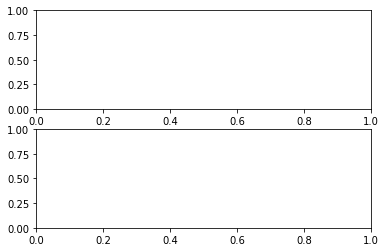

In [107]:
fig, ax1 = plt.subplots(2,1)
ax1.scatter(train_data['TimeMin'],train_data['PickupCount'], label='Train', c='black')
ax2.scatter(test_data['TimeMin'],test_data['PickupCount'], c='blue', label='Test')
ax.legend()

In [88]:
ax.scatter(X_train,y_train)

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(15, 15))

count = 0
for variable in predictors:
    ax[count%2][int(count/2)].scatter(X_train['TimeMin'],X_train['PickupCount'])
    ax[count%2][int(count/2)].set_xlabel(variable)
    count = count + 1


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

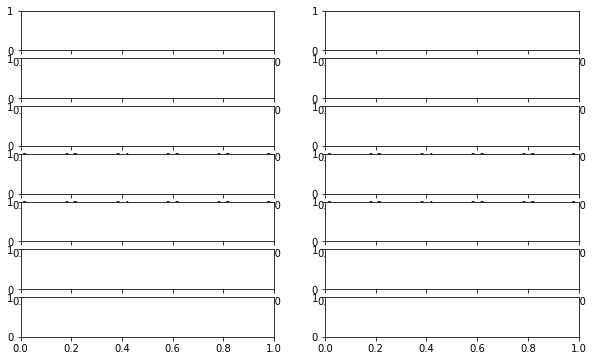

In [86]:
fig, ax = plt.subplots(7,2, figsize=(10,6))

# scatter plots can be created with either the scatter or plot functions (with an additional argument)
# ax.plot(data['TimeMin'],data['PickupCount'])
# ax.plot(X_test, y_test, '*', label="test data", c = "black")

dummy_train = np.arange(np.min(X_train),np.max(X_train),1).reshape(-1,1)

# let's unpack the dictionary to its elements (items) which is the k and Regressor
for k, model in KNNModels.items():
    predictions = model.predict(dummy_train) 
    ax.plot(dummy_train, predictions, label="{}-NN".format(k))

ax.legend();


In [ ]:
# Plot predictions vs actual
# your code here 



In [77]:
type(X_train)

pandas.core.series.Series

In [78]:
y_train

346     32
1027     9
126     19
814     54
908     43
        ..
298     12
319     42
587     27
399     48
141      8
Name: PickupCount, Length: 1000, dtype: int64

**2.3 [3 pts]. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**



In [ ]:
# your code here



**2.4 [3 pts]. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.



In [ ]:
# your code here



**2.5 [9 pts]. Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

*your answer here*

2. What does an $R^2$ score of $0$ mean?  

*your answer here*

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

*your answer here*

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

*your answer here*

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

*your answer here*

6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

*your answer here*

## <div class="exercise"> <b> Question 3 [23 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1 [3 pts]**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2 [3 pts]**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4 [2 pts]**. Report the estimates for the slope and intercept for the fitted linear model.

**3.5 [3 pts]**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6 [10 pts]**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers



**3.1 [3 pts]. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.**



In [ ]:
# your code here


**3.2 [3 pts]. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.**

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  



In [ ]:
# your code here


In [ ]:
# your code here 


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.



In [ ]:
# your code here


**3.4 [2 pts]. Report the estimates for the slope and intercept for the fitted linear model.**



In [ ]:
# your code here


**3.5 [3 pts]. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 



In [ ]:
# your code here



**3.6 [10 pts]. Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

*your answer here*

2. What does the sign of the slope of the fitted linear model convey about the data?  

*your answer here*

3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 

*your answer here*

4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  

*your answer here*

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

*your answer here*


## <div class="exercise"> <b> Question 4 [12 pts] </b></div>

We next consider investigating how the day of the week is associated with pickups to improve both the predictive accuracy of the models and help with more in depth interpretations.  We begin by using the non-parametric *k*-NN approach.   

**4.1 [2 pts]**. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday. 

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.

**4.3 [3 pts]**. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot). 

**4.4 [4 pts]**. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.






### Answers


**4.1 [2 pts]. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday.** 



In [ ]:
# your code here

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.


In [ ]:
# your code here



**4.3 [3 pts]. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot).**


In [ ]:
# your code here




**4.4 [4 pts]. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.**


*your answer here*


##### <div class="exercise"> <b> Question 5 [27 pts] </b></div>

Finally we turn to multiple regression models to see if there is a weekend affect.  Note: Use sklearn to do the modeling unless otherwise stated.


**5.1 [6 pts]**. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.

**5.2 [6 pts]**. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.

**5.3 [3 pts]**. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.

**5.4 [4 pts]**. Determine if the model in 5.3 is a more accurate model than the *k*-NN model in 4.2.  Why do you suppose this is the case?

**5.5 [5 pts]**. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot of the training data). How does this compare to the plot from 4.3?

**5.6 [3 pts]**. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.

### Answers

**5.1 [6 pts]. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:**

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.


In [ ]:
# your code here

*your answer here*


**5.2 [6 pts]. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.**



In [ ]:
# your code here

**5.3 [3 pts]. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.**


In [ ]:
# your code here


**5.4 [4 pts]. Determine if the model in 5.3 is a more predictive model than the *k*-NN model in 4.2.  Why do you suppose this is the case?**



In [ ]:
# your code here

*your answer here*

**5.5 [5 pts]. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot). How does this compare to the plot from 4.3?**



In [ ]:
# your code here

*your answer here*

**5.6 [3 pts]. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.**

*your answer here*